In [ ]:
# Mengimpor pustaka yang esensial untuk manipulasi data,
# pemodelan, dan pra-pemrosesan.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Penyeimbangan Dataset ---
#
# Latar Belakang: Dataset Bot-IoT sangat tidak seimbang, dengan jumlah data
# serangan (attack=1) jauh lebih banyak daripada data normal (attack=0).
# Model yang dilatih pada data seperti ini akan cenderung bias terhadap kelas mayoritas.
#
# Tujuan: Membuat dataset yang lebih seimbang dengan melakukan undersampling
# pada kelas mayoritas (serangan).

# Membaca dua file dataset. Dtype untuk kolom port (5 dan 7) secara eksplisit
# diatur ke string untuk menghindari peringatan tipe data campuran.
df_1 = pd.read_csv('../data/data_1.csv', dtype={5: str, 7: str})
df_2 = pd.read_csv('../data/data_2.csv', dtype={5: str, 7: str})

# 1. Menggabungkan semua data normal (attack == 0) dari kedua file.
df_0_all = pd.concat([
    df_1[df_1['attack'] == 0],
    df_2[df_2['attack'] == 0]
])

# 2. Menggabungkan semua data serangan (attack == 1) dari kedua file.
df_1_all = pd.concat([
    df_1[df_1['attack'] == 1],
    df_2[df_2['attack'] == 1]
])

# 3. Melakukan undersampling: Mengambil sampel acak sebanyak 20.000 baris
# dari data serangan. `random_state` digunakan untuk memastikan hasil yang sama setiap kali.
df_1_sampled = df_1_all.sample(n=20000, random_state=42)

# 4. Menggabungkan kembali data normal dengan data serangan yang telah di-undersample.
df_balanced = pd.concat([df_0_all, df_1_sampled])

# 5. Mengacak urutan baris (shuffling) untuk memastikan data terdistribusi secara
# acak dan tidak berurutan berdasarkan kelas. Indeks di-reset.
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Memeriksa distribusi kelas akhir untuk memverifikasi hasil penyeimbangan.
print(df_balanced['attack'].value_counts())

attack
1    20000
0     6934
Name: count, dtype: int64


In [3]:
# Menampilkan daftar nama kolom untuk inspeksi awal.
print(df_balanced.columns.tolist())

['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'smac', 'dmac', 'sum', 'min', 'max', 'soui', 'doui', 'sco', 'dco', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'category', 'subcategory ']


In [4]:
# Membersihkan nama kolom dengan menghapus spasi di awal atau akhir.
# Langkah ini penting untuk mencegah kesalahan saat mengakses kolom berdasarkan nama.
df_balanced.columns = df_balanced.columns.str.strip()

In [5]:
# --- Seleksi Fitur (Feature Selection) ---
#
# Berdasarkan penelitian terkait dataset Bot-IoT, beberapa fitur diidentifikasi
# tidak relevan atau berpotensi menyebabkan overfitting pada model, sedangkan untuk fitur
# category dan subcategory dihilangkan dikarenakan penelitian ini hanya berfokus pada
# deteksi serangan, tidak menentukan kategori maupun subkategori.
columns_to_drop = [
    'pkSeqID', 'saddr', 'daddr', 'ltime', 'stime', 'seq', 'category', 'subcategory'
]
df_balanced = df_balanced.drop(columns=columns_to_drop, errors='ignore')

In [6]:
# Menampilkan informasi ringkas tentang DataFrame setelah penghapusan kolom.
# Ini digunakan untuk memeriksa tipe data, jumlah kolom, dan nilai non-null.
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26934 entries, 0 to 26933
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   flgs    26934 non-null  object 
 1   proto   26934 non-null  object 
 2   sport   26534 non-null  object 
 3   dport   26534 non-null  object 
 4   pkts    26934 non-null  int64  
 5   bytes   26934 non-null  int64  
 6   state   26934 non-null  object 
 7   dur     26934 non-null  float64
 8   mean    26934 non-null  float64
 9   stddev  26934 non-null  float64
 10  smac    0 non-null      float64
 11  dmac    0 non-null      float64
 12  sum     26934 non-null  float64
 13  min     26934 non-null  float64
 14  max     26934 non-null  float64
 15  soui    0 non-null      float64
 16  doui    0 non-null      float64
 17  sco     0 non-null      float64
 18  dco     0 non-null      float64
 19  spkts   26934 non-null  int64  
 20  dpkts   26934 non-null  int64  
 21  sbytes  26934 non-null  int64  
 22

In [7]:
# Menampilkan lima baris pertama dari DataFrame untuk verifikasi visual.
df_balanced.head()

,flgs,proto,sport,dport,pkts,bytes,state,dur,mean,stddev,...,sco,dco,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
0,e,udp,52841,53,2,176,INT,5.047946,0.000000,0.0,...,NaN,NaN,2,0,176,0,0.198100,0.19810,0.00000,0
1,e,tcp,60134,6788,2,120,RST,0.000114,0.000114,0.0,...,NaN,NaN,1,1,60,60,8771.929688,0.00000,0.00000,1
2,e,tcp,56304,15224,2,120,RST,0.033741,0.033741,0.0,...,NaN,NaN,1,1,60,60,29.637531,0.00000,0.00000,1
3,e,tcp,59460,25280,2,120,RST,0.032499,0.032499,0.0,...,NaN,NaN,1,1,60,60,30.770178,0.00000,0.00000,1
4,e,tcp,54892,1883,6,662,RST,0.000244,0.000244,0.0,...,NaN,NaN,3,3,456,206,20491.802734,8196.72168,8196.72168,1


In [8]:
# Menghapus kolom-kolom yang teridentifikasi hanya berisi nilai null (NaN).
# Kolom-kolom ini tidak memberikan informasi apa pun untuk proses pemodelan.
df_balanced.drop(columns=["smac", "dmac", "soui", "doui", "sco", "dco"], inplace=True)

In [9]:
# Menghapus baris-baris duplikat untuk memastikan setiap entri data unik.
df_balanced.drop_duplicates(inplace=True)

In [10]:
# Mengidentifikasi dan menghitung nilai yang hilang (missing values)
# pada setiap kolom.
missing = df_balanced.isnull().sum()
print(missing[missing > 0])

sport    307
dport    307
dtype: int64


In [11]:
# Menangani nilai yang hilang dengan menghapus baris yang mengandungnya.
# Karena jumlah baris yang hilang relatif kecil, metode penghapusan (listwise deletion)
# dapat diterima tanpa menyebabkan kehilangan informasi yang signifikan.
df_balanced.dropna(subset=["sport", "dport"], inplace=True)

In [12]:
# Menampilkan informasi ringkas tentang DataFrame setelah pembersihan.
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26265 entries, 0 to 26933
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   flgs    26265 non-null  object 
 1   proto   26265 non-null  object 
 2   sport   26265 non-null  object 
 3   dport   26265 non-null  object 
 4   pkts    26265 non-null  int64  
 5   bytes   26265 non-null  int64  
 6   state   26265 non-null  object 
 7   dur     26265 non-null  float64
 8   mean    26265 non-null  float64
 9   stddev  26265 non-null  float64
 10  sum     26265 non-null  float64
 11  min     26265 non-null  float64
 12  max     26265 non-null  float64
 13  spkts   26265 non-null  int64  
 14  dpkts   26265 non-null  int64  
 15  sbytes  26265 non-null  int64  
 16  dbytes  26265 non-null  int64  
 17  rate    26265 non-null  float64
 18  srate   26265 non-null  float64
 19  drate   26265 non-null  float64
 20  attack  26265 non-null  int64  
dtypes: float64(9), int64(7), object(5)
memor

In [13]:
# Menampilkan lima baris teratas setelah penghapusan kolom null.
df_balanced.head()

,flgs,proto,sport,dport,pkts,bytes,state,dur,mean,stddev,...,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
0,e,udp,52841,53,2,176,INT,5.047946,0.000000,0.0,...,0.000000,0.000000,2,0,176,0,0.198100,0.19810,0.00000,0
1,e,tcp,60134,6788,2,120,RST,0.000114,0.000114,0.0,...,0.000114,0.000114,1,1,60,60,8771.929688,0.00000,0.00000,1
2,e,tcp,56304,15224,2,120,RST,0.033741,0.033741,0.0,...,0.033741,0.033741,1,1,60,60,29.637531,0.00000,0.00000,1
3,e,tcp,59460,25280,2,120,RST,0.032499,0.032499,0.0,...,0.032499,0.032499,1,1,60,60,30.770178,0.00000,0.00000,1
4,e,tcp,54892,1883,6,662,RST,0.000244,0.000244,0.0,...,0.000244,0.000244,3,3,456,206,20491.802734,8196.72168,8196.72168,1


In [14]:
# Memisahkan dataset menjadi matriks fitur (X) dan vektor target (y).
# 'attack' adalah variabel dependen yang akan diprediksi oleh model.
target = "attack"
X = df_balanced.drop(columns=[target])
y = df_balanced[target]

In [15]:
# Memeriksa kembali distribusi kelas pada variabel target setelah
# semua proses pembersihan data selesai.
print(y.value_counts())

attack
1    19941
0     6324
Name: count, dtype: int64


In [16]:
# --- Pra-pemrosesan: Encoding Fitur Kategorikal (Kardinalitas Tinggi) ---
#
# Menerapkan Label Encoding pada fitur 'sport' dan 'dport'.
# Label Encoding mengubah setiap nilai unik kategorikal menjadi sebuah integer unik.
# Metode ini dipilih untuk fitur dengan kardinalitas tinggi (banyak nilai unik)
# untuk menghindari pembuatan dimensi yang terlalu besar (seperti pada One-Hot Encoding).
high_card_cat = ["sport", "dport"]
for col in high_card_cat:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [17]:
# Menampilkan distribusi nilai untuk kolom 'sport' setelah di-encode.
print(X['sport'].value_counts())

sport
8004    705
7444    693
8208    685
2375    683
8241    676
       ... 
3017      1
474       1
774       1
7541      1
6912      1
Name: count, Length: 9942, dtype: int64


In [18]:
# Menampilkan distribusi nilai untuk kolom 'dport' setelah di-encode.
print(X['dport'].value_counts())

dport
8976     5125
11826    1726
11827     631
2395      293
8977      236
         ... 
2631        1
10925       1
4753        1
5612        1
5449        1
Name: count, Length: 12477, dtype: int64


In [19]:
# --- Pra-pemrosesan: Encoding Fitur Kategorikal (Kardinalitas Rendah) ---
#
# Menerapkan One-Hot Encoding pada fitur dengan jumlah kategori unik yang sedikit.
# One-Hot Encoding membuat kolom biner baru untuk setiap kategori. Ini adalah
# metode yang lebih disukai untuk data kategorikal nominal (tanpa urutan)
# karena tidak menciptakan hubungan ordinal artifisial antar kategori.
low_card_cat = ["proto", "state", "flgs"]

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe_result = ohe.fit_transform(X[low_card_cat])
ohe_cols = ohe.get_feature_names_out(low_card_cat)

# Menghapus kolom kategorikal asli dari DataFrame fitur (X).
# Langkah ini penting untuk menghindari duplikasi data, karena informasi
# dari kolom-kolom ini sekarang sudah direpresentasikan dalam format one-hot-encoded
# yang akan digabungkan kembali nanti.
X.drop(columns=["proto", "state", "flgs"], inplace=True)

X_ohe = pd.DataFrame(ohe_result, columns=ohe_cols, index=X.index)

In [20]:
# Menggabungkan semua set fitur yang telah diproses (label-encoded
# dan one-hot-encoded) menjadi satu matriks fitur akhir.
X_encoded = pd.concat([X, X_ohe], axis=1)

In [21]:

df_encoded = pd.concat([X_encoded, y], axis=1)

In [22]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26265 entries, 0 to 26933
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sport            26265 non-null  int64  
 1   dport            26265 non-null  int64  
 2   pkts             26265 non-null  int64  
 3   bytes            26265 non-null  int64  
 4   dur              26265 non-null  float64
 5   mean             26265 non-null  float64
 6   stddev           26265 non-null  float64
 7   sum              26265 non-null  float64
 8   min              26265 non-null  float64
 9   max              26265 non-null  float64
 10  spkts            26265 non-null  int64  
 11  dpkts            26265 non-null  int64  
 12  sbytes           26265 non-null  int64  
 13  dbytes           26265 non-null  int64  
 14  rate             26265 non-null  float64
 15  srate            26265 non-null  float64
 16  drate            26265 non-null  float64
 17  proto_icmp       

In [23]:
df_encoded.head()

,sport,dport,pkts,bytes,dur,mean,stddev,sum,min,max,...,flgs_e F,flgs_e t,flgs_e &,flgs_e *,flgs_e d,flgs_e g,flgs_e r,flgs_e s,flgs_eU,attack
0,7108,8976,2,176,5.047946,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9003,11459,2,120,0.000114,0.000114,0.0,0.000114,0.000114,0.000114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,8004,1648,2,120,0.033741,0.033741,0.0,0.033741,0.033741,0.033741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,8827,3718,2,120,0.032499,0.032499,0.0,0.032499,0.032499,0.032499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,7644,2395,6,662,0.000244,0.000244,0.0,0.000244,0.000244,0.000244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [24]:
# --- Tahap 1: Filter Menggunakan Pearson Correlation ---
corr_matrix = df_encoded.corr()
corr_target = abs(corr_matrix['attack'])
sorted_corr = corr_target.sort_values(ascending=False)
top_n_corr_features = 20

# Ambil N fitur teratas (indeks [1:] untuk membuang korelasi 'attack' dengan dirinya sendiri)
top_corr_features_list = sorted_corr[1:top_n_corr_features+1].index.tolist()
print(f"Ditemukan {top_n_corr_features} fitur teratas berdasarkan korelasi dengan 'attack':")
print(sorted_corr[1:top_n_corr_features+1])
print(f"\nFitur yang terpilih untuk tahap selanjutnya: {top_corr_features_list}")
print("-" * 60, "\n")

Ditemukan 20 fitur teratas berdasarkan korelasi dengan 'attack':
proto_udp    0.913273
proto_tcp    0.886573
state_RST    0.803942
state_CON    0.626481
state_INT    0.603046
dport        0.230019
mean         0.229665
max          0.222461
dur          0.209585
min          0.203278
sum          0.186762
spkts        0.143595
pkts         0.138226
flgs_e       0.137014
sbytes       0.130610
flgs_e s     0.129647
bytes        0.126242
state_REQ    0.116448
rate         0.111405
dpkts        0.089978
Name: attack, dtype: float64

Fitur yang terpilih untuk tahap selanjutnya: ['proto_udp', 'proto_tcp', 'state_RST', 'state_CON', 'state_INT', 'dport', 'mean', 'max', 'dur', 'min', 'sum', 'spkts', 'pkts', 'flgs_e', 'sbytes', 'flgs_e s', 'bytes', 'state_REQ', 'rate', 'dpkts']
------------------------------------------------------------ 



In [25]:
# --- Tahap 2: Penyempurnaan dengan Random Forest ---
# Siapkan data X dan y HANYA dengan fitur-fitur teratas dari tahap 1
X_top_corr = df_encoded[top_corr_features_list]
y = df_encoded['attack']

# Latih model RandomForest untuk mendapatkan feature importance
# n_jobs=-1 akan menggunakan semua core CPU untuk mempercepat proses
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_top_corr, y)

# Buat DataFrame untuk menampilkan feature importances
feature_importances_df = pd.DataFrame({
    'feature': X_top_corr.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

final_n_features = 10
final_features_list = feature_importances_df.head(final_n_features)['feature'].tolist()

print(f"Peringkat kepentingan fitur dari Random Forest (dari {top_n_corr_features} kandidat):")
print(feature_importances_df)
print("\n")
print(f"--- HASIL AKHIR: {final_n_features} FITUR TERPILIH ---")
print("Fitur-fitur final yang direkomendasikan untuk model klasifikasi Anda adalah:")
print(final_features_list)
print("-" * 60)


Peringkat kepentingan fitur dari Random Forest (dari 20 kandidat):
      feature  importance
0   proto_udp    0.242833
1   proto_tcp    0.167823
2       bytes    0.120568
3   state_RST    0.095511
4      sbytes    0.060114
5       dport    0.056170
6   state_CON    0.049217
7         dur    0.047442
8        rate    0.029774
9        pkts    0.024439
10  state_INT    0.022543
11      spkts    0.019237
12        sum    0.015606
13       mean    0.012627
14      dpkts    0.010185
15        max    0.008330
16     flgs_e    0.006180
17        min    0.005279
18   flgs_e s    0.004624
19  state_REQ    0.001499


--- HASIL AKHIR: 10 FITUR TERPILIH ---
Fitur-fitur final yang direkomendasikan untuk model klasifikasi Anda adalah:
['proto_udp', 'proto_tcp', 'bytes', 'state_RST', 'sbytes', 'dport', 'state_CON', 'dur', 'rate', 'pkts']
------------------------------------------------------------


C:\Users\albia\AppData\Local\Temp\ipykernel_25068\2902404569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_df.head(final_n_features), palette='viridis')


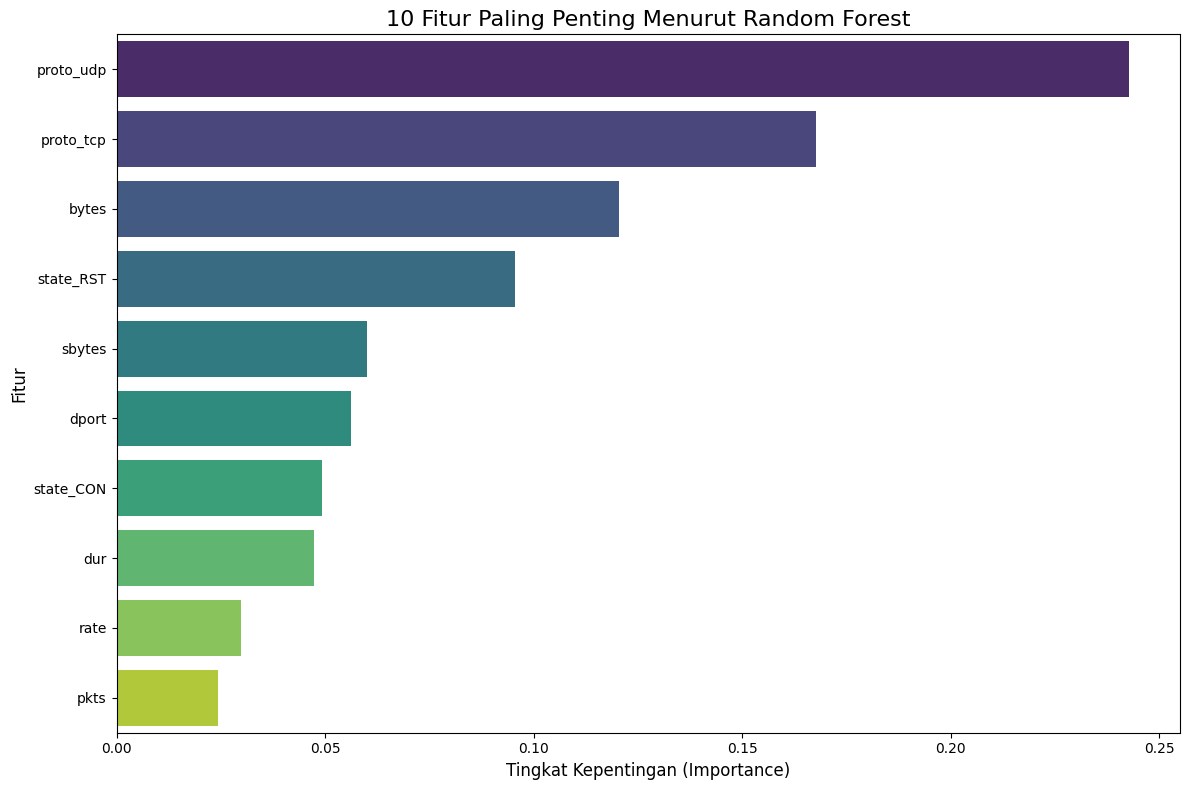

In [26]:
# (Opsional) Visualisasi Feature Importance untuk laporan Anda
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(final_n_features), palette='viridis')
plt.title(f'{final_n_features} Fitur Paling Penting Menurut Random Forest', fontsize=16)
plt.xlabel('Tingkat Kepentingan (Importance)', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
X_final = df_encoded[final_features_list]
df_encoded_final = pd.concat([X_final, y], axis=1)

In [28]:
df_encoded_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26265 entries, 0 to 26933
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   proto_udp  26265 non-null  float64
 1   proto_tcp  26265 non-null  float64
 2   bytes      26265 non-null  int64  
 3   state_RST  26265 non-null  float64
 4   sbytes     26265 non-null  int64  
 5   dport      26265 non-null  int64  
 6   state_CON  26265 non-null  float64
 7   dur        26265 non-null  float64
 8   rate       26265 non-null  float64
 9   pkts       26265 non-null  int64  
 10  attack     26265 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 2.4 MB


In [29]:
df_encoded_final.head()

,proto_udp,proto_tcp,bytes,state_RST,sbytes,dport,state_CON,dur,rate,pkts,attack
0,1.0,0.0,176,0.0,176,8976,0.0,5.047946,0.198100,2,0
1,0.0,1.0,120,1.0,60,11459,0.0,0.000114,8771.929688,2,1
2,0.0,1.0,120,1.0,60,1648,0.0,0.033741,29.637531,2,1
3,0.0,1.0,120,1.0,60,3718,0.0,0.032499,30.770178,2,1
4,0.0,1.0,662,1.0,456,2395,0.0,0.000244,20491.802734,6,1


In [30]:
df_encoded_final.to_csv("../Data/Bot_IoT_processedV3.csv", index=False)